In [1]:
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm.keras import TqdmCallback

from src.data.ascad import AscadRandomKey
from src.dlla.hw import NUM_CLASSES, fetch_traces, plot_predictions, dlla_hw, p_gradient_dl_la, encode
from src.dlla.wegener import dlla_p_gradient_wegener, make_mlp_wegener
from src.tools.lists import random_divide
from src.tools.plotter import init_plots, plot_p_gradient, PALETTE_GRADIENT
from src.tvla.tvla import Tvla

init_plots()

TRACE_LENGTH = 1400

In [2]:
ascad = AscadRandomKey().default

x_prof, y_prof, x_att, y_att = fetch_traces(ascad)
y_att_unmasked = encode(ascad.attack.unmasked_labels())

### Model creation

With model hyperparameters to be optimized.

In [3]:
model_parameters = {
    'activation': ['relu'],
    'optimizer': [Adam(lr=0.001)],
    'losses': ['categorical_crossentropy'],
    'batch_size': list(np.linspace(100, 300, 5).astype(int)),
    'epochs': list(np.linspace(5, 20, 4).astype(int))
}

def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(1400,)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [4]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name=".cache/talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [5]:
best_model = make_mlp(x_prof, y_prof, x_att, y_att, {
    'activation':'relu',
    'optimizer': Adam(lr=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
})[1]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [6]:
best_model.predict(x_att[:1])[0]

array([0.00035207, 0.00796736, 0.06945357, 0.1960875 , 0.2959929 ,
       0.28453815, 0.11577725, 0.02833224, 0.00149901], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [7]:
np.sum(best_model.predict(x_att[:1])[0] * range(8 + 1))

4.246780715882778

In [8]:
dlla_hw(best_model, x_att, y_att)

(0.0, 0.7328001331619796)

### Plot prediction distribution for all traces.

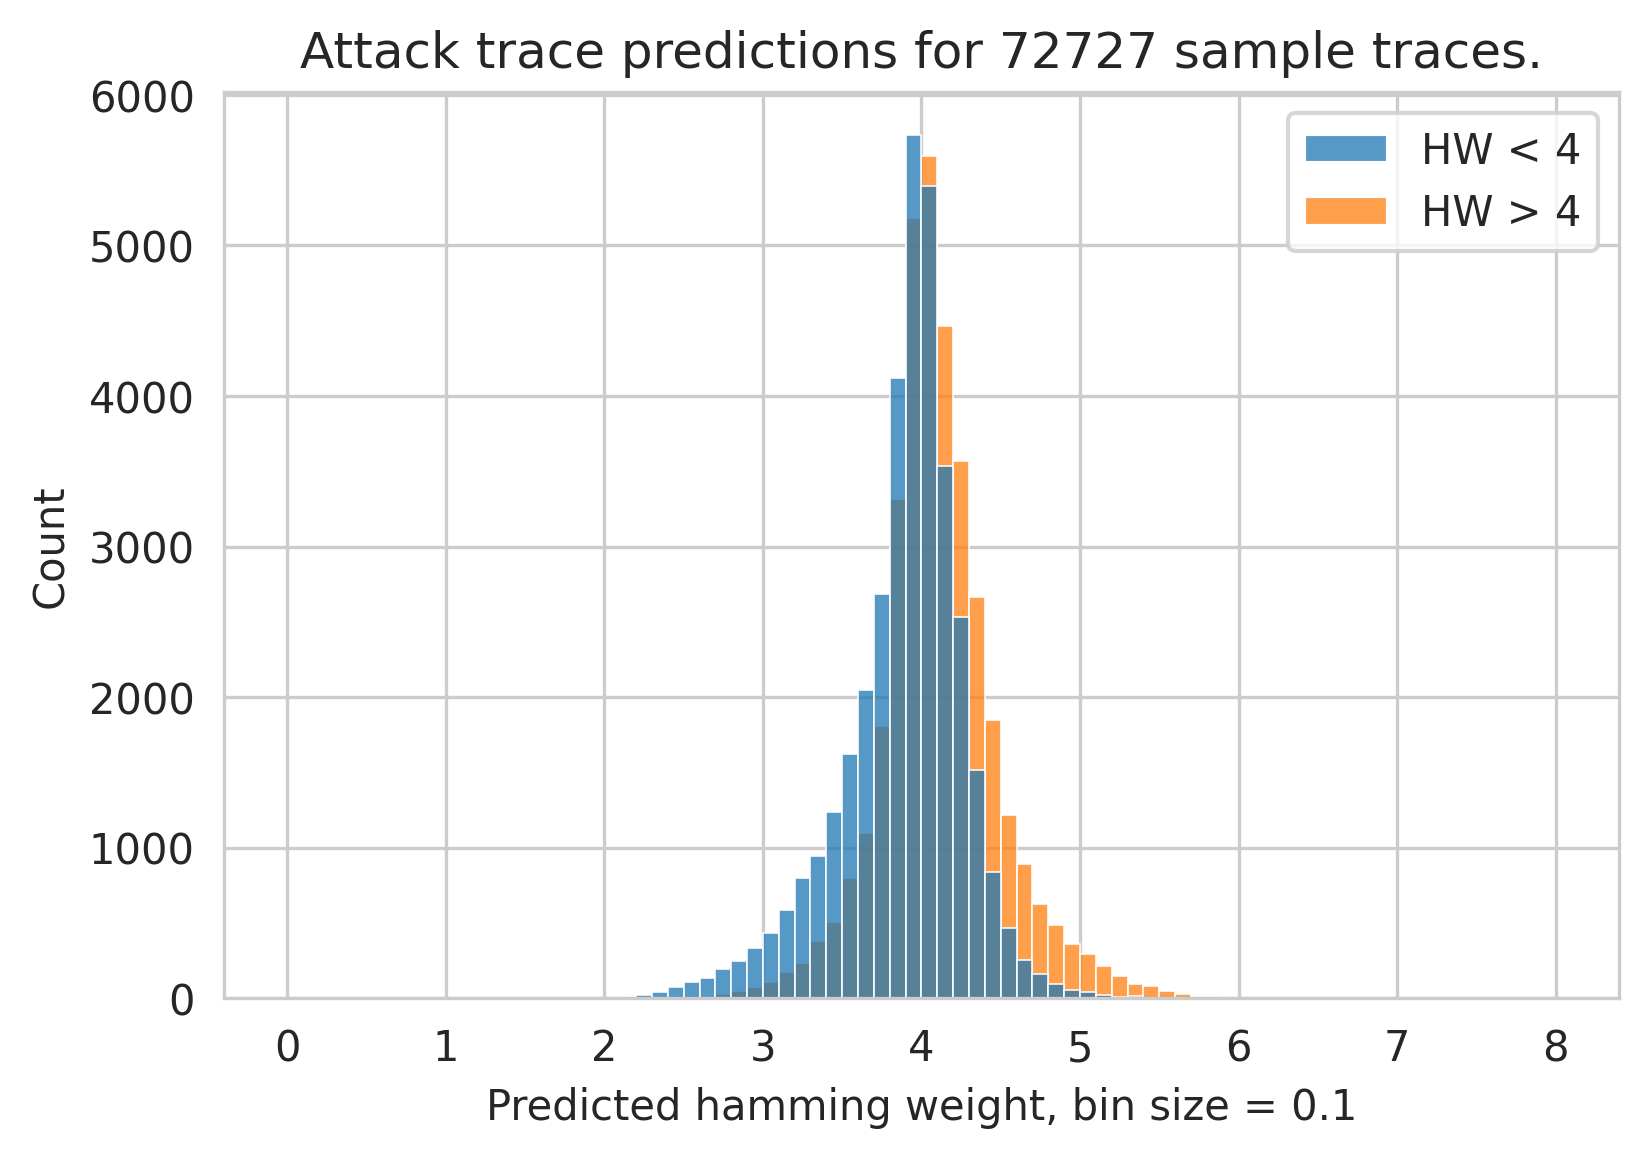

In [9]:
plot_predictions(best_model, x_att, y_att)

### Plot p-gradient.

In [10]:
def split_traces(x, y):
    yam = np.argmax(y, axis=1)
    a = x[np.where(yam < 4)]
    b = x[np.where(yam > 4)]

    min_len = min(len(a), len(b))
    return a[:min_len], b[:min_len]

A_ATT, B_ATT = split_traces(x_att, y_att_unmasked)

In [11]:
MAX_LEN = round(len(A_ATT) / 2)
TVLA_AB = Tvla(TRACE_LENGTH)
TVLA_AB.add(A_ATT[:MAX_LEN], B_ATT)

100%|██████████| 18153/18153 [00:44<00:00, 404.12it/s]


In [12]:
TVLA_BB = Tvla(TRACE_LENGTH)
TVLA_BB.add(*random_divide(B_ATT))

100%|██████████| 18043/18043 [00:44<00:00, 403.06it/s]


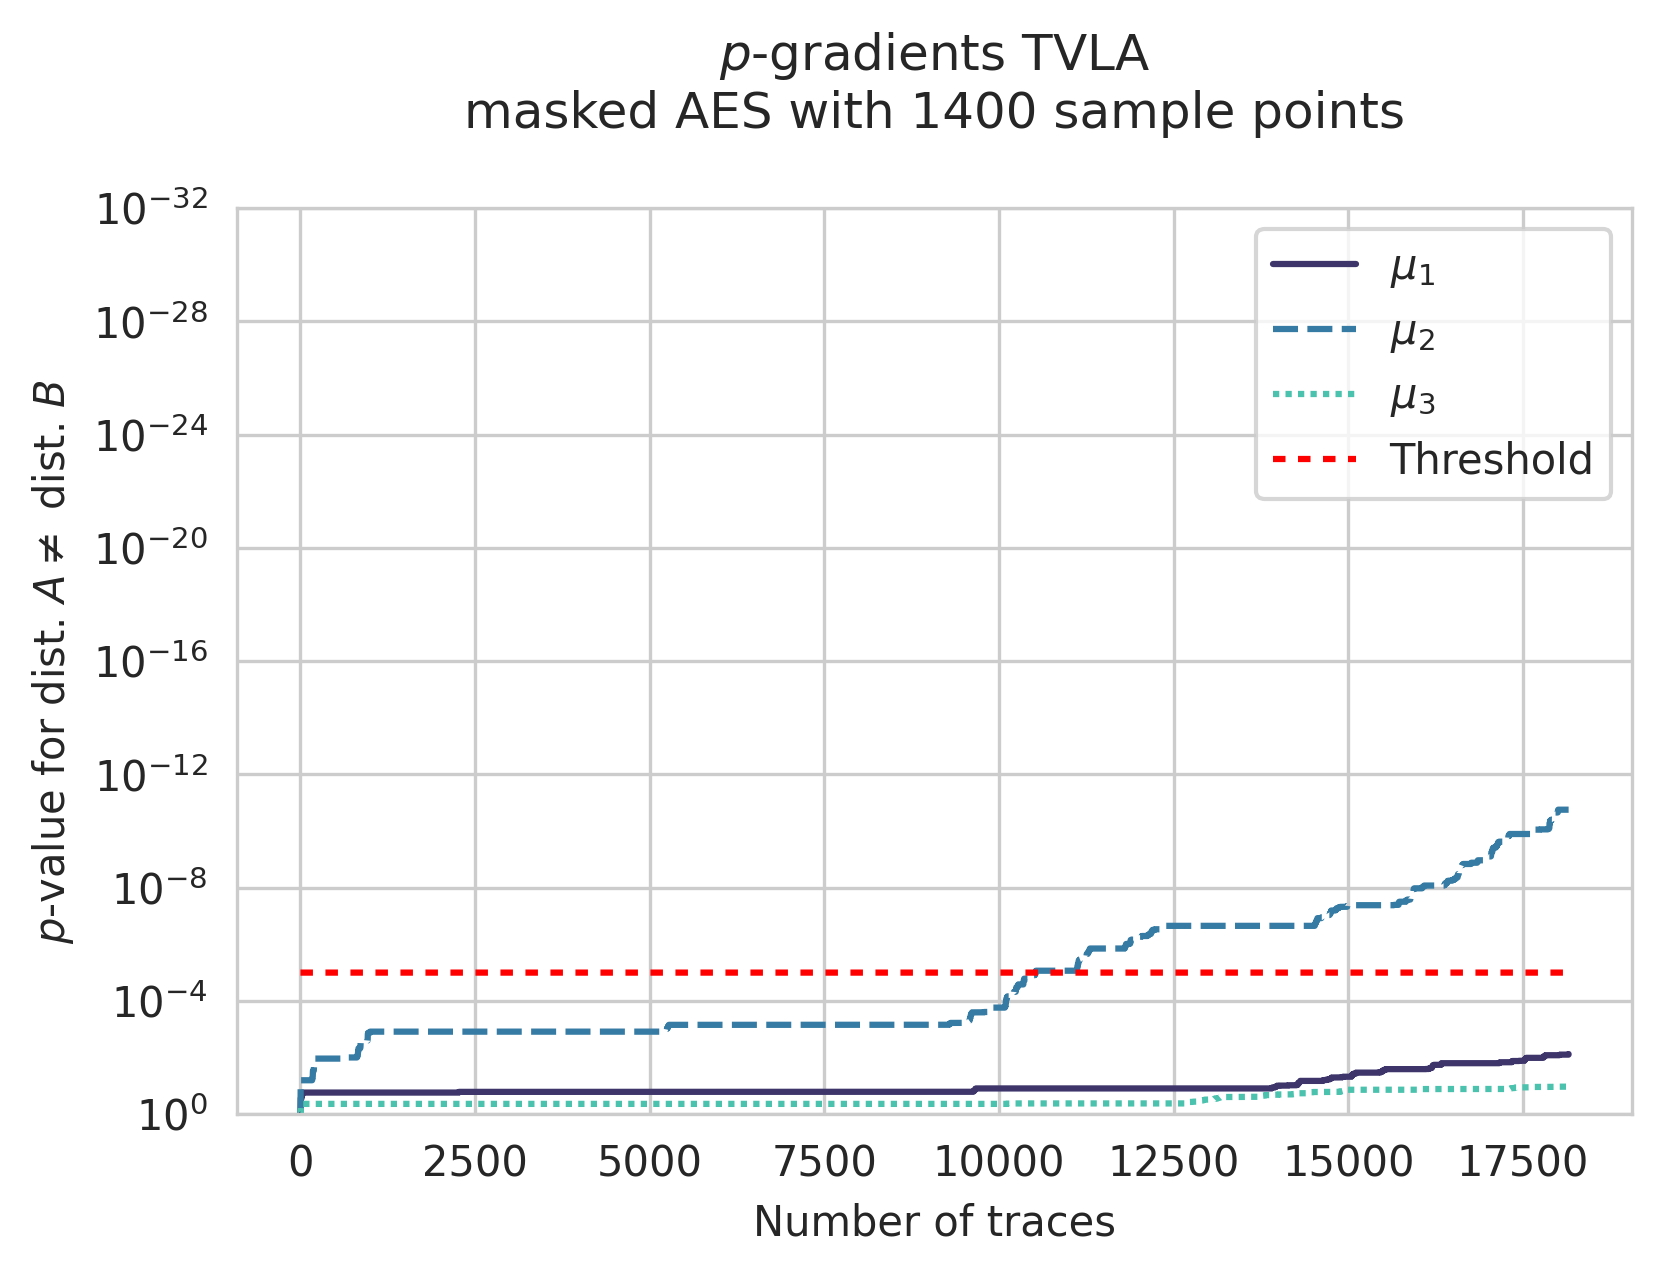

In [13]:
plot_p_gradient(dict([(f"$\\mu_{{{d}}}$", TVLA_AB.p_gradient(d)) for d in range(1, 4)]),
                "$p$-gradients TVLA\nmasked AES with 1400 sample points\n", palette=PALETTE_GRADIENT)

/home/berg/Documents/Afstudeer/LA/src/tvla/tvla.py:137: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  g.set(yscale="log", ylabel="$p$-value for dist. $A \\neq$ dist. $B$", xlabel="Sample point",


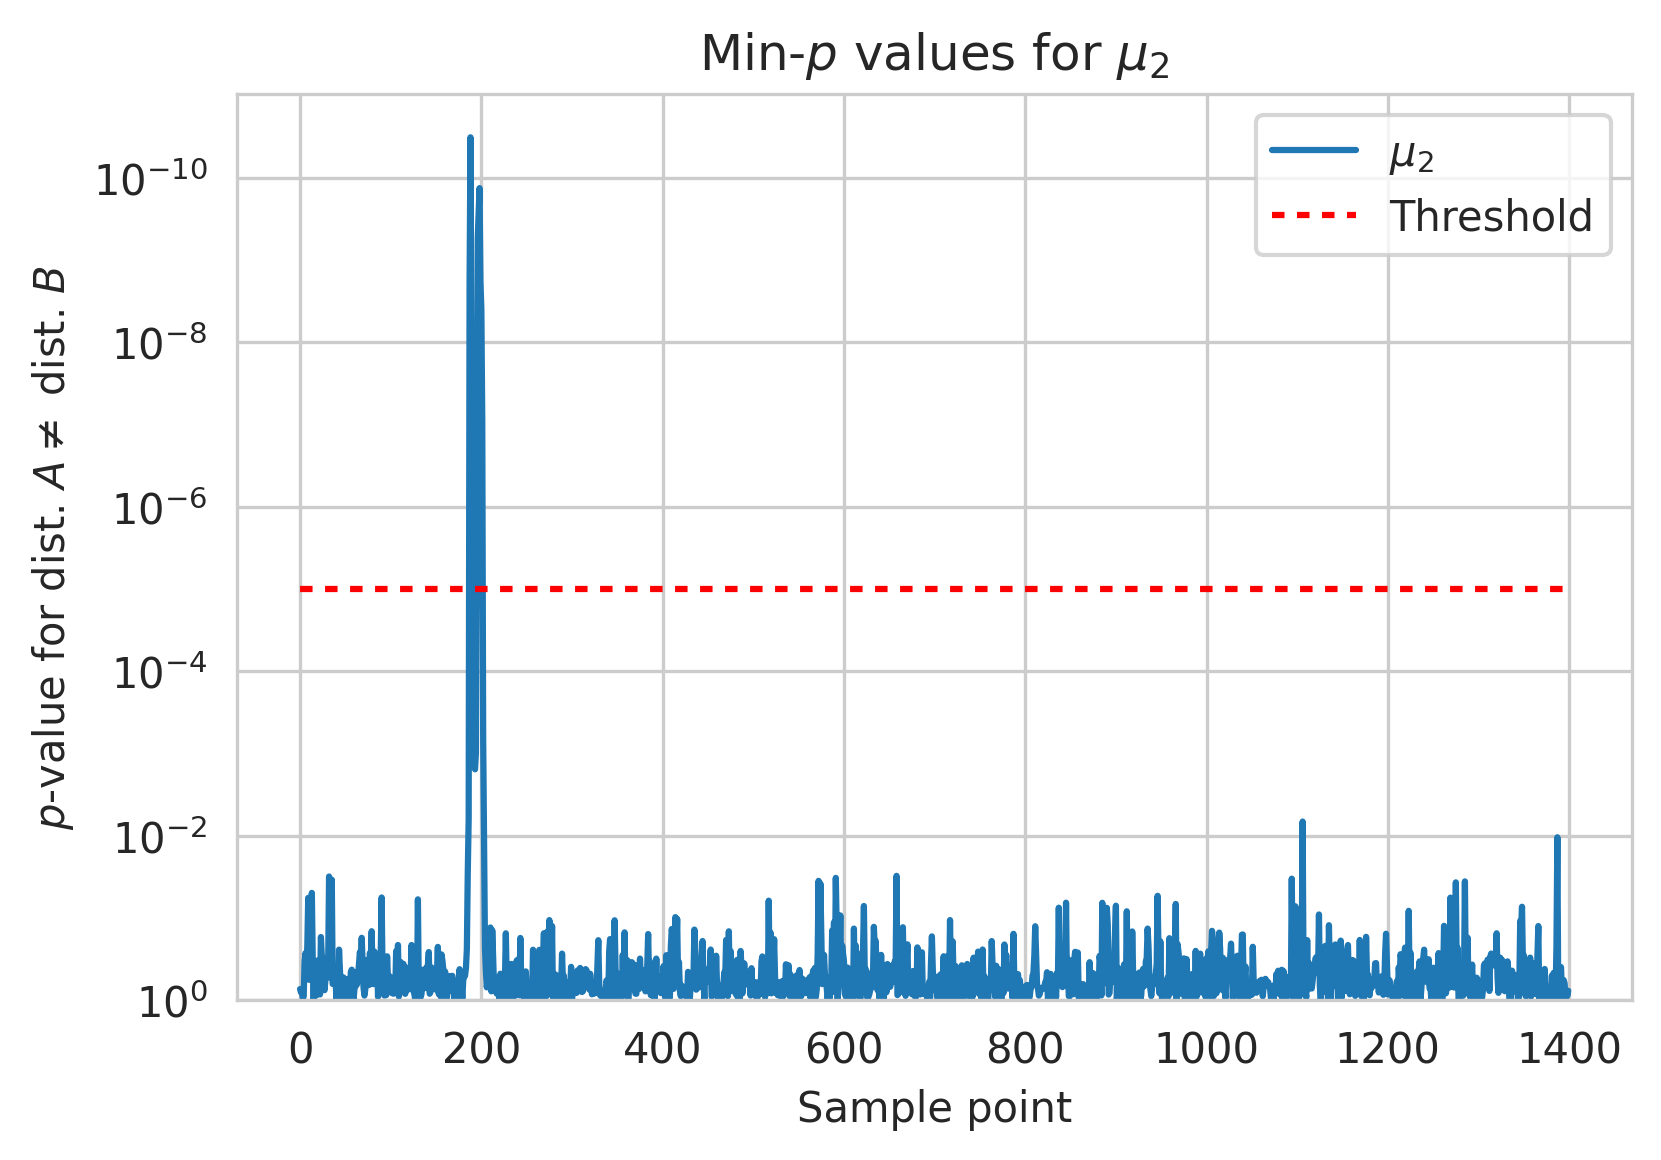

In [14]:
TVLA_AB.plot_min_p(2)

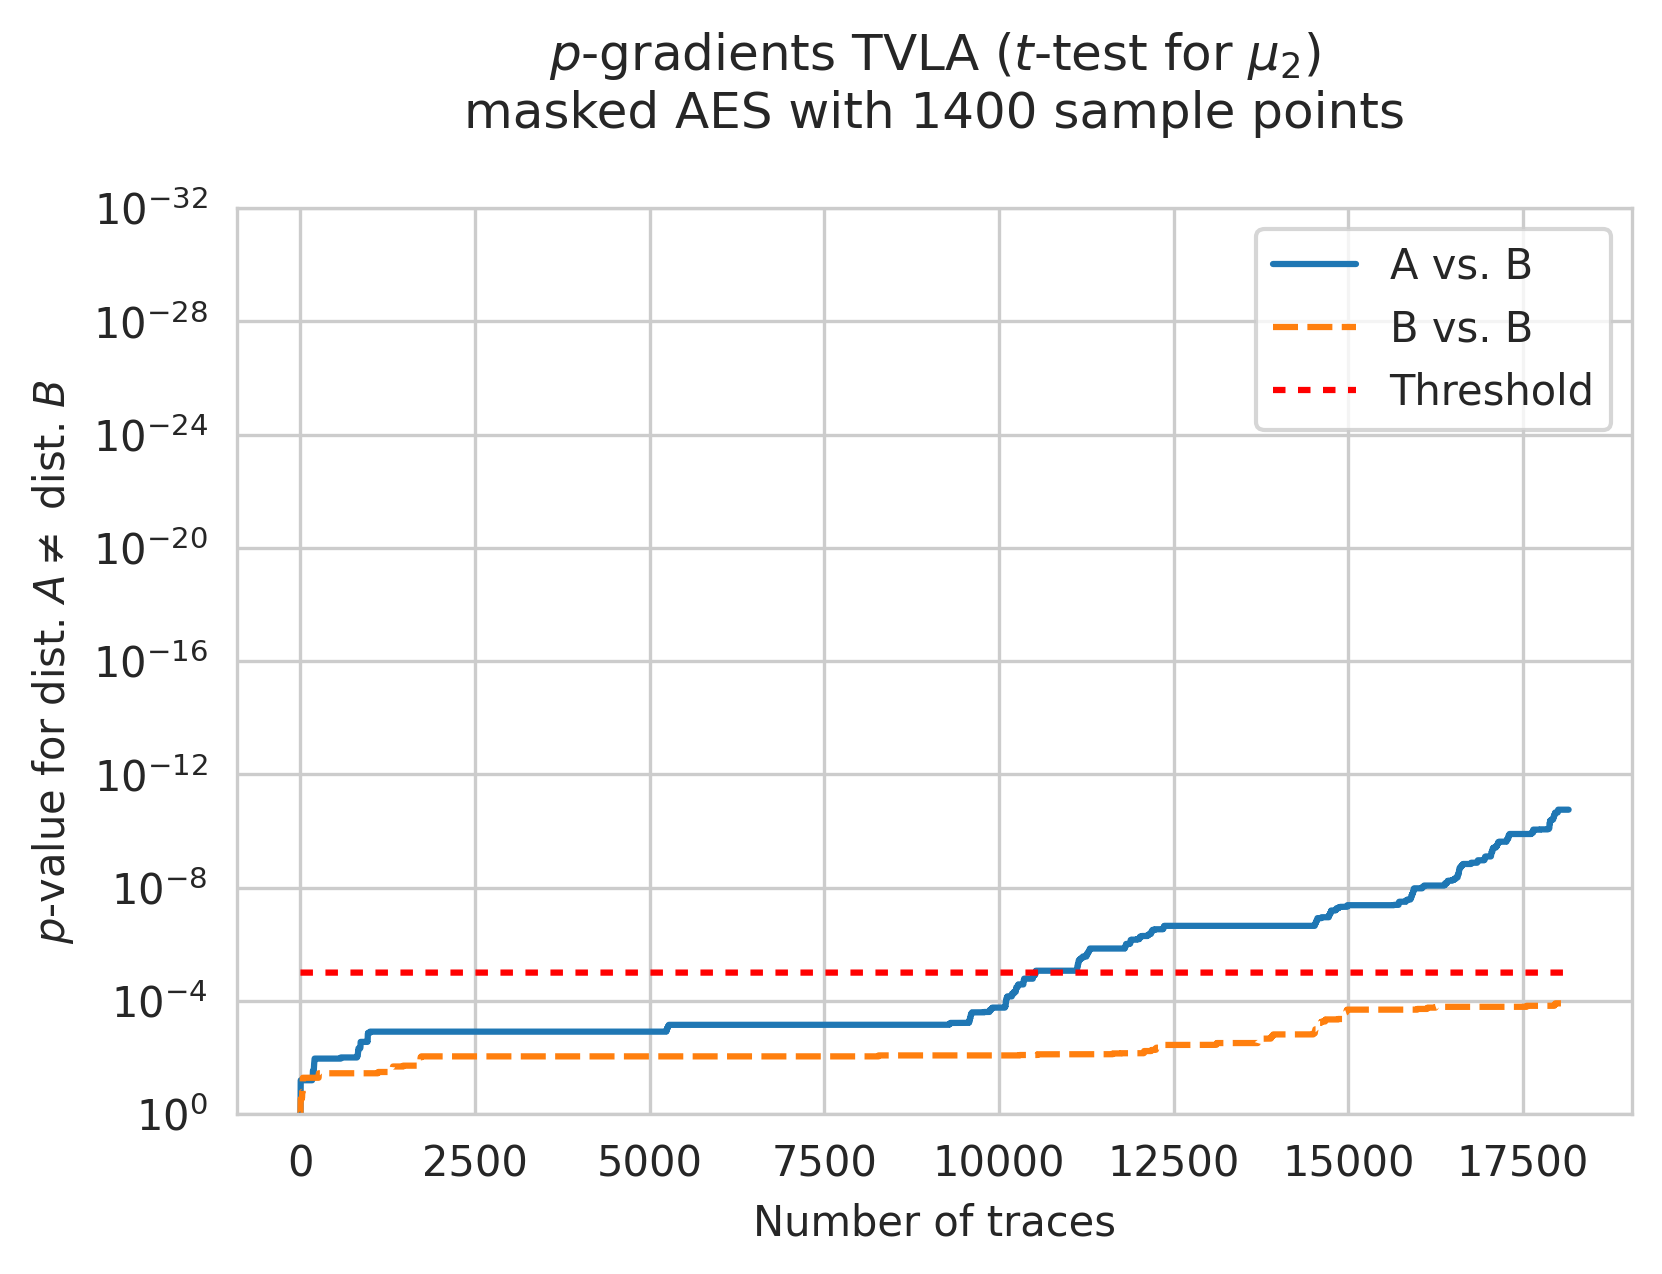

In [15]:
plot_p_gradient({
    "A vs. B": TVLA_AB.p_gradient(2),
    "B vs. B": TVLA_BB.p_gradient(2)
}, "$p$-gradients TVLA ($t$-test for $\\mu_2$)\nmasked AES with 1400 sample points\n")

In [16]:
PG_DLLA_9 = p_gradient_dl_la(best_model, x_att, y_att, 1000)["A vs. B"]

In [17]:
MODEL_WEGENER = make_mlp_wegener(x_prof, y_prof, x_att, y_att)
PG_DLLA_2 = dlla_p_gradient_wegener(MODEL_WEGENER, x_att, y_att)

Epoch 1/5


ValueError: in user code:

    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10250 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/berg/anaconda3/envs/LA/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 2 and 9 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_1/dense_8/Softmax, IteratorGetNext:1)' with input shapes: [?,2], [?,9].


# TODO: DL-LA 2 class

In [ ]:
plot_p_gradient({
    "DL-LA (9-class)": np.array(PG_DLLA_9),
    "DL-LA (2-class)": np.array(PG_DLLA_2),
    "TVLA $\\mu_2$": TVLA_AB.p_gradient(2)
},"$p$-gradients\nmasked AES with 1400 sample points\n")